# Playing with sequences

Implementation of recurrent neural networks (RNNs) for sequence modelling is a good motivation for getting to know Keras. In this post I'll fit a coarse model to Karpathy's Shakespeare text data and explore how to evaluate such a model.

Let's start by loading the relevant packages and data:

In [1]:
from __future__ import print_function
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM, Recurrent
import numpy as np
import random
import sys

Using TensorFlow backend.


Karpathy's blog post <a href="http://karpathy.github.io/2015/05/21/rnn-effectiveness/">The Unreasonable Effectiveness of Recurrent Neural Networks</a> is a great introduction to RNNs, and the example below (including the data set itself) is based on Karpathy's <a href="https://github.com/box121209/char-rnn">Torch code</a>.

Let's import that data as a string of about 1.1M characters, and partition it into training and test sets:

In [2]:
path = "data/text/shakespeare.txt"
text = open(path).read().lower()
print('# characters:', len(text))

chars = set(text)
print('# distinct:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

# divide into training and test sets:
n_train = int(len(text)/2)
text_train = text[0:n_train]
text_test = text[n_train:len(text)]

print('training length:', len(text_train))
print('test length:', len(text_test))

# characters: 1115394
# distinct: 39
training length: 557697
test length: 557697


# Training a sequence model

Training will be by back-propagation, not on the single full training sequence, but on many snippets from this sequence, each of length '<tt>unroll</tt>'. (For the terminology, see the figure below.) Here, we extract these snippets are then convert then into feature vectors <tt>X</tt> (sequence snippet) and response <tt>y</tt> (next character to follow): 

In [3]:
# cut the text in semi-redundant sequences of maxlen characters
unroll = 20
step = 3
sentences = []
next_chars = []
for i in range(0, n_train - unroll, step):
    sentences.append(text_train[i: i + unroll])
    next_chars.append(text_train[i + unroll])
print('# sequences:', len(sentences))

# convert to feature vector + next character:
X = np.zeros((len(sentences), unroll, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

# sequences: 185893


In this post we will train an RNN smaller than that in Karpathy's blog (because I'm training on my Macbook and not on a GPU). So the results won't be as spectacular - but the aim is more to get familiar with implementing them in Keras.

As mentioned above, the training is by back-propagation on a short 'un-rolled' neural network as in this figure:

<img src="img/rnn_dag.png" width=500>

We've set the length to <tt>unroll = 20</tt>. This means that each time we later run the network, it will need to be initialised with 20 characters. This choice of length makes no difference to the number of parameters (weights) of the network - as these are constant under translation in time. On the other hand, training time is proportional to the length <tt>unroll</tt>.

Karpathy and others typically use two hidden layers of (512, 512) units for this problem. I'm using only (128, 32). This is comparable in number of weights to the MNIST network trained in the previous post.

In [4]:
# build the model: 2 stacked LSTM

nhidden = [128,32] # e.g. [512, 512]
dropout = 0.2

model = Sequential()
model.add(LSTM(nhidden[0], return_sequences=True, input_shape=(unroll, len(chars))))
model.add(Dropout(dropout))
model.add(LSTM(nhidden[1], return_sequences=False))
model.add(Dropout(dropout))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
model.summary()

--------------------------------------------------------------------------------
Initial input shape: (None, 20, 39)
--------------------------------------------------------------------------------
Layer (name)                  Output Shape                  Param #             
--------------------------------------------------------------------------------
LSTM (lstm)                   (None, 20, 128)               86016               
Dropout (dropout)             (None, 20, 128)               0                   
LSTM (lstm)                   (None, 32)                    20608               
Dropout (dropout)             (None, 32)                    0                   
Dense (dense)                 (None, 39)                    1287                
Activation (activation)       (None, 39)                    0                   
--------------------------------------------------------------------------------
Total params: 107911
----------------------------------------------------

Note that the number of parameters between a layer with <i>n</i> units and an interior layer with <i>h</i> units is given by <i>4h(n+h+1)</i>. The 4 corresponds to the 4 gates of an LSTM unit (labelled red in the diagram below) and the 1 corresponds to the bias weights.

<img src="img/lstm.png" width="500">

Similarly, the number of parameters from a layer with <i>h</i> units to output layer with <i>n</i> units is <i>n(h+1)</i>.

Next, training and save the model: this took about 10 hours on my Macbook, and it's not recommended to run it as we'll load the pre-saved model weights for analysis below.

(In fact, <a href="data/text/text_model_20x39_128_32_39sm_output.txt">this file</a> contains the actual code that I ran, and its verbose output. After every 5 training iterations it tested the synthetic output of the model - as we'll do below.)

In [ ]:
model.fit(X, y, batch_size=128, nb_epoch=100, verbose=1)
np.save("data/text/text_model_39x20_128_32_39sm.npy", model.get_weights())

# Model evaluation

Let's load our previously trained model:

In [5]:
# declare:
unroll = 20
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(unroll, len(chars))))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

# compile:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

# load weights:
model.set_weights(np.load("data/text/text_model_39x20_128_32_39sm.npy"))

# show:
model.summary()

--------------------------------------------------------------------------------
Initial input shape: (None, 20, 39)
--------------------------------------------------------------------------------
Layer (name)                  Output Shape                  Param #             
--------------------------------------------------------------------------------
LSTM (lstm)                   (None, 20, 128)               86016               
LSTM (lstm)                   (None, 32)                    20608               
Dense (dense)                 (None, 39)                    1287                
Activation (activation)       (None, 39)                    0                   
--------------------------------------------------------------------------------
Total params: 107911
--------------------------------------------------------------------------------


We'll need a couple of helper functions:

In [6]:
import math

def entropy(pred): 
    return sum([- p * math.log(p) for p in pred])

def sample(a, temperature=1.0):
    # samples an index from a probability array;
    # higher temperature raises the entropy and vice versa
    a = np.log(a) / temperature
    a = np.exp(a) / np.sum(np.exp(a))
    return np.argmax(np.random.multinomial(1, a, 1))

The first thing we can do is simply eyeball synthetic output generated by the model. In the following code, we seed with a 20-character string (e.g. a random sequence from the test data), and then generate successive characters from model intialised with this string:

In [7]:
# try adjusting the temperature:
temperature = 0.5
quote_length = 200

# pick random:
start = random.randint(0, len(text_test) - unroll - 1)
init_quote = text_test[start : start + unroll]

# or pick your own:
init_quote =  "such stuff as dreams"
init_quote =  "to be or not to be, "

generated = init_quote
print('\n', '-' * 50)
print("Seed:")
sys.stdout.write(init_quote)
print('\n', '-' * 50)
sys.stdout.write(generated)
for i in range(quote_length):
    x = np.zeros((1, unroll, len(chars)))
    for t, char in enumerate(generated):
        x[0, t, char_indices[char]] = 1.

    preds = model.predict(x, verbose=0)[0]
    next_index = sample(preds, temperature)
    next_char = indices_char[next_index]
    generated = generated[1:] + next_char

    sys.stdout.write(next_char)
    sys.stdout.flush()
print('\n', '-' * 50)


 --------------------------------------------------
Seed:
to be or not to be, 
 --------------------------------------------------
to be or not to be, that with the love of partace with this a menty true hath make a shall we to in her to you,
the bow the cation years with did them have stand shall shall and heart that the present to grace of him, an
 --------------------------------------------------


Next, we run a long stretch of the test data through each model, and build a data frame consisting of: 
<ul>
<li>current character;
<li>actual next character and its predicted probability; 
<li>most probable predicted next character and its probability; 
<li>entropy of the predicted distribution.
</ul>

In [9]:
import pandas as pd

length = 20000
start_index = random.randint(unroll, len(text_test) - length - 1)
window = text_test[start_index - unroll: start_index]
results = []
for i in range(length):
    
    # predict from model:
    x = np.zeros((1, unroll, len(chars)))
    for t, char in enumerate(window):
        x[0, t, char_indices[char]] = 1.
    preds = model.predict(x, verbose=0)[0]
    
    # find current, next and predicted characters; and advance window:
    this_char = window[unroll-1]
    next_char = text_test[start_index + i]
    predicted = np.argmax(preds)
    window = window[1:] + next_char

    # record results:
    results.append((this_char,
                    next_char,
                    preds[char_indices[next_char]],
                    indices_char[predicted],
                    preds[predicted],
                    entropy(preds)
                   ))

# make into data frame:
df = pd.DataFrame(results)
df.columns = ["current","next","next_prob","pred","pred_prob","entropy"]

For example, let's inspect a portion of the table corresponding to a short random stretch of the test text. We look, in particular, to compare the columns '<tt>next</tt>' and '<tt>pred</tt>', the latter being simply the character with maximum predicted probability. Typically, in stretches where these two columns coincide we expect to see decreasing entropy, i.e. the prediction becoming more confident. But notice that entropy also tends to jump up when '<tt>current</tt>' is a space or newline:

In [14]:
# for example:
n = random.randint(0, length - 20)
df[n:n+20]

,current,next,next_prob,pred,pred_prob,entropy
2993,e,r,0.235644,,0.697582,0.917475
2994,r,e,0.000890,,0.969488,0.181678
2995,e,,0.160936,f,0.437578,2.011931
2996,,c,0.037474,i,0.126646,2.781093
2997,c,o,0.591324,o,0.591324,1.162472
2998,o,m,0.864713,m,0.864713,0.631613
2999,m,e,0.947117,e,0.947117,0.272133
3000,e,s,0.203825,,0.412826,1.780819
3001,s,,0.950550,,0.950550,0.282607
3002,,y,0.074071,t,0.288110,2.403330


Our aim is to use this data to evaluate the model quantitatively. Naively, the first thing we think of is to ask, how many times is the next character the one with maximum predicted probability? We might also ask how the probability assigned to the actual next character is distributed. And we might ask how confident is the prediction distribution (i.e. the softmax output) in general - and how does that confidence vary depending on the current character?

The following plots try to capture some of these questions in a single visualisation. The plotting instructions are wrapped in a function '<tt>model_view</tt>' so that we can easily apply the same view to subsets of the data conditioned on the current character (below):

Nr data points: 20000
Correct prediction: 0.4683


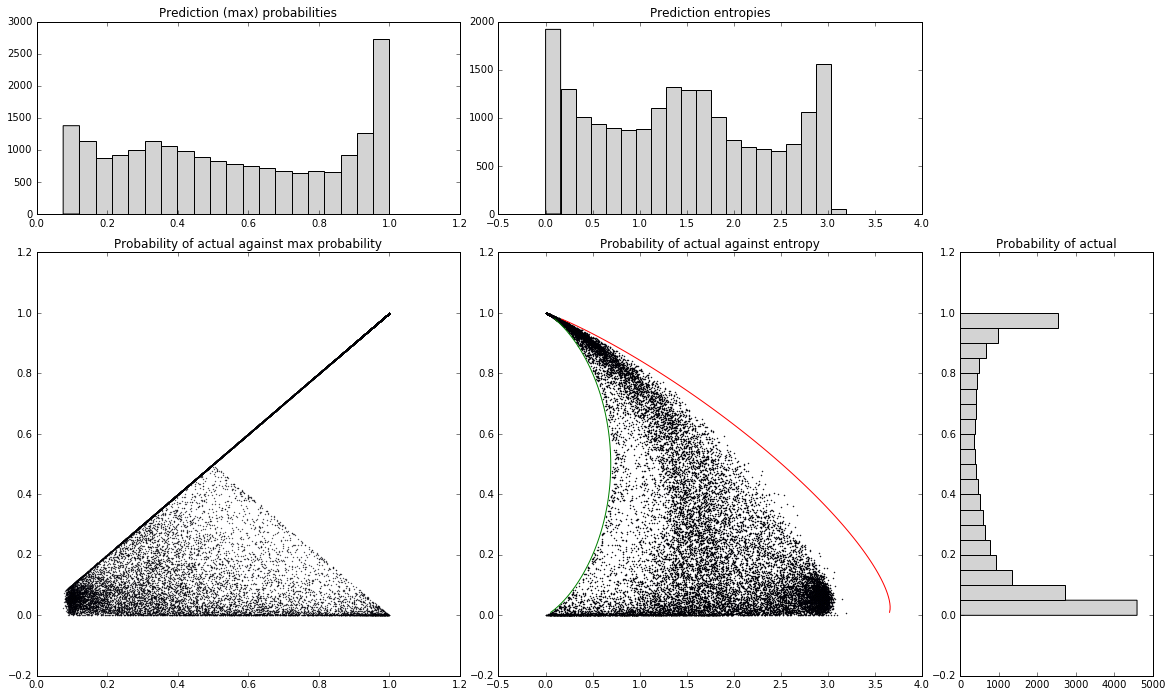

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

def model_view(df, dotsize=0.1):
    print("Nr data points:", df.shape[0])
    print("Correct prediction:", sum(df.next==df.pred)/float(df.shape[0]))
    plt.figure(figsize=(20,20))
    ax1 = plt.subplot2grid((5,5), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((5,5), (0, 2), colspan=2)
    ax3 = plt.subplot2grid((5,5), (1, 0), rowspan=2, colspan=2, sharex=ax1)
    ax4 = plt.subplot2grid((5,5), (1, 2), rowspan=2, colspan=2, sharex=ax2, sharey=ax3)
    ax5 = plt.subplot2grid((5,5), (1, 4), rowspan=2, sharey=ax3)
    ax1.hist(df['pred_prob'], color='lightgrey', bins=20)
    ax1.set_title("Prediction (max) probabilities")
    ax2.hist(df['entropy'], color='lightgrey', bins=20)
    ax2.set_title("Prediction entropies")
    ax3.scatter(df['pred_prob'], df['next_prob'], s=dotsize)
    ax3.set_title("Probability of actual against max probability")
    # some embellishments for the 4th plot:
    N = len(chars)
    y = np.arange(0.01,0.99,0.01)
    x = [-p*math.log(p)-(1-p)*math.log(1-p) for p in y]
    z = [-p*math.log(p)-(N-1)*(1-p)/(N-1)*math.log((1-p)/(N-1)) for p in y]
    ax4.scatter(df['entropy'], df['next_prob'], s=0.1)
    ax4.plot(x,y, c='green')
    ax4.plot(z,y, c='red')
    ax4.scatter(df['entropy'], df['next_prob'], s=dotsize)
    ax4.set_title("Probability of actual against entropy")
    ax5.hist(df['next_prob'], color='lightgrey', bins=20, orientation='horizontal')
    ax5.set_title("Probability of actual")
    plt.show()
    
# apply to the full data frame:
model_view(df)

The first score is the 'prediction' accuracy of ~46%. Clearly we like that figure to be high. Nevertheless, it is based on the naive assumption that we 'predict' whatever character has the highest softmax probability. That's fine if the distribution is confident (low entropy), but if it's uncertain (higher entropy), then the maximum probability may be only negligibly higher than that of other characters. I'll come back to this point below.

In the plots, I've aligned the various axes horizontally and vertically. So the viewer should focus on the two scatterplots - the histograms represent their marginal distributions in the <tt>x</tt> and <tt>y</tt> directions.

Various structures are immediately apparent, including entropy bounds which I've added in colour to the second scatterplot. Green is the minimum entropy possible, and corresponds to only two characters having positive probability - all others having probability zero. Red is the maximum entropy possible (for the given probability of the actual next character). This corresponds to all other 38 characters being predicted as equally likely.

So what are we looking for in these plots that will help us prefer one model to another?

<ul>
<li> <b>Good:</b> Higher probability assigned to the actual next character. This corresponds to more weight on the upper diagonal of the left-hand scatterplot, and to the 'fin tip' of the right-hand (shark's fin) plot. Note that as this character is assigned more probability, the entropy is automatically reduced.

<li> <b>Bad:</b> Low entropy at the base of the shark's fin - i.e. high confidence in the wrong character! Equivalently, the lower right corner of the left-hand plot.
</ul>

What about the high entropy at the lower right of the shark's fin? If there's genuine uncertainty in the data then we need the model to tell us that. For example, it might indicate that we've hit a change-point in the data generation process. I'll return to this point in the next section.

Before that, how does the picture change as we impose various conditions on the current character? When this character is one of ',' or '.' or ':' then the prediction (typically a space) is very confident, whereas if it's a space or newline then the prediction becomes very uncertain:

Nr data points: 164
Correct prediction: 0.69512195122


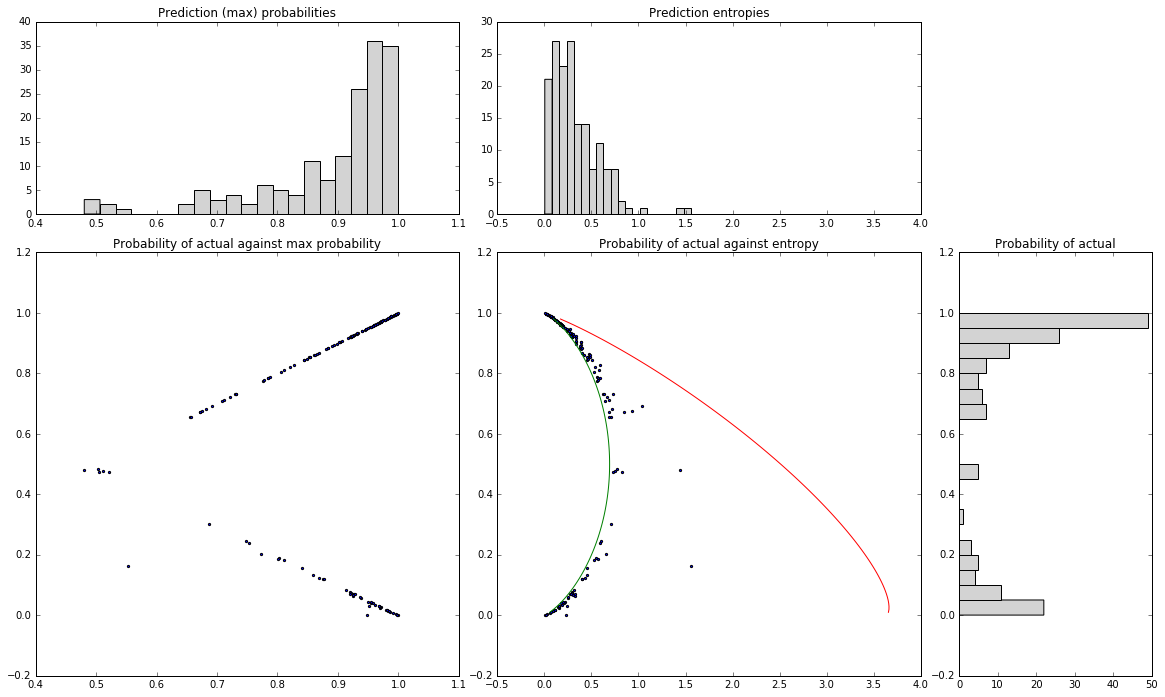

In [16]:
# try imposing various conditions on the current character:

c = '.'
sub_df = df[df.current == c]
model_view(sub_df, dotsize=5)

# How well calibrated is the model?

Success rate in predicting the next character is a misleading measure of RNN model preformance, because prediction from maximum probability may not be the right strategy where the entropy is high. A better approach is to ask about calibration of the model: that is, do predicted probabilities match observed frequencies?

The next plot tests this. It says: look at all events for which the (maximum) prediction probability is (say) 20%. Is the proportion of these events for which that's the actual next character <i>also</i> 20%? If it is, then we'll say the predictive distribution is well-calibrated.

In the plot below, good calibration corresponds to the blue curve being close to the grey line:

<function matplotlib.pyplot.show>

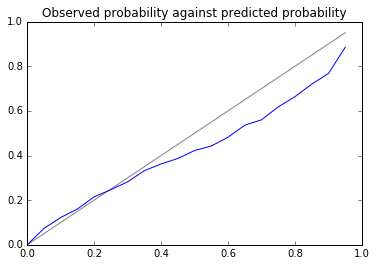

In [17]:
delta = 0.05
x = np.arange(0,1,delta)
y = np.zeros(len(x))
for i in range(len(x)):
    p = x[i]
    sub_df = df[(df.pred_prob >= p) & (df.pred_prob < p+delta)]
    if sub_df.shape[0]>0:
        y[i] = sub_df[sub_df.next == sub_df.pred].shape[0]/float(sub_df.shape[0])
    
plt.plot(x,x, c='grey')
plt.plot(x,y, 'b-')
plt.title("Observed probability against predicted probability")
plt.show

What we see in this case is that the model is good at low softmax proabilities, but tends to be over-confident at the higher end. (This would explain why lower temperature gave more realistic results when we used the model to generate synthetic text.)

For a larger, more expensive, RNN I would hope to see the curve above lining up more closely with the grey line. 